In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
import skfuzzy as fuzz

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['image.cmap'] = 'gray'

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [ ]:
def plot_images(images, titles, cmap=None):
    """Helper function to plot multiple images side-by-side."""
    n = len(images)
    plt.figure(figsize=(5 * n, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if cmap and len(images[i].shape) == 2:
            plt.imshow(images[i], cmap=cmap)
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
   

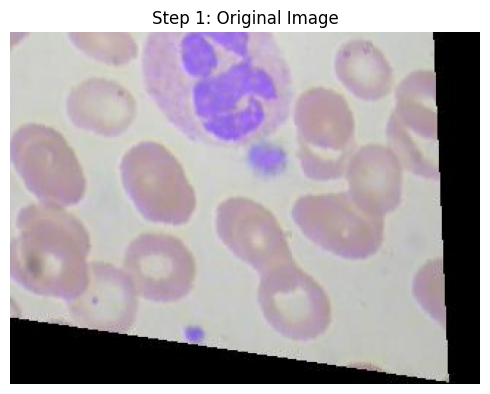

In [ ]:
def load_sample_image(dataset_path, cell_type="NEUTROPHIL"):
    train_path = os.path.join(dataset_path, "dataset2-master", "dataset2-master", "images", "TRAIN", cell_type)
    image_name = os.listdir(train_path)[0]
    image_path = os.path.join(train_path, image_name)
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
image_rgb = load_sample_image(dataset_path)


plot_images([image_rgb], ["Step 1: Original Image"])

In [ ]:
def prepare_pixels(image, threshold=15):
    h, w, c = image.shape
    mask = np.any(image > threshold, axis=2)
    filtered_pixels = image[mask].reshape(-1, 3).astype(np.float32)
    return filtered_pixels, mask, h, w

pixel_values_filtered, non_black_mask, h, w = prepare_pixels(image_rgb)

print(f"Original image shape: {image_rgb.shape}")
print(f"Flattened pixels for clustering: {pixel_values_filtered.shape}")

Original image shape: (240, 320, 3)
Flattened pixels for clustering: (63590, 3)


Running K-Means...


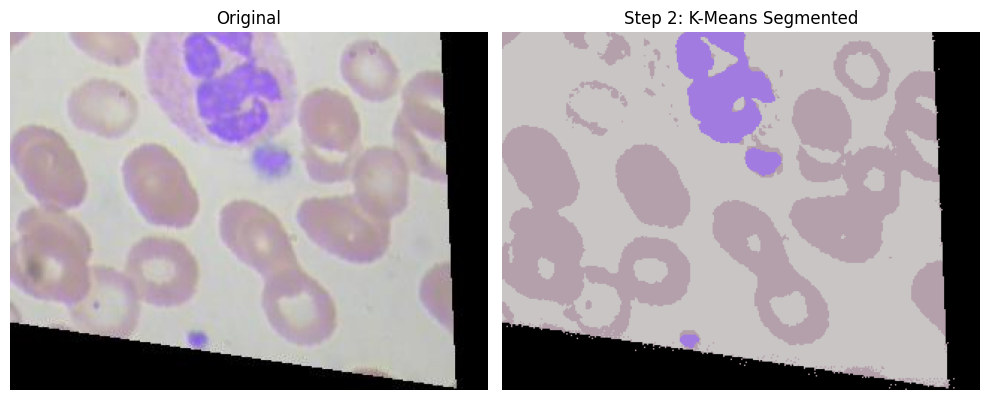

In [ ]:
def apply_kmeans(filtered_pixels, k=3):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(filtered_pixels)
    return labels, model.cluster_centers_

def reconstruct_image(labels, centers, mask, h, w):
    full_labels = np.full((h, w), -1)
    full_labels[mask] = labels
    segmented = np.zeros((h, w, 3), dtype=np.uint8)
    segmented[mask] = centers[labels]
    return segmented, full_labels


print("Running K-Means...")
kmeans_labels, filtered_centers = apply_kmeans(pixel_values_filtered)
segmented_image_kmeans, full_labels_k = reconstruct_image(kmeans_labels, filtered_centers, non_black_mask, h, w)


plot_images([image_rgb, segmented_image_kmeans], ["Original", "Step 2: K-Means Segmented"])

Running Fuzzy C-Means...


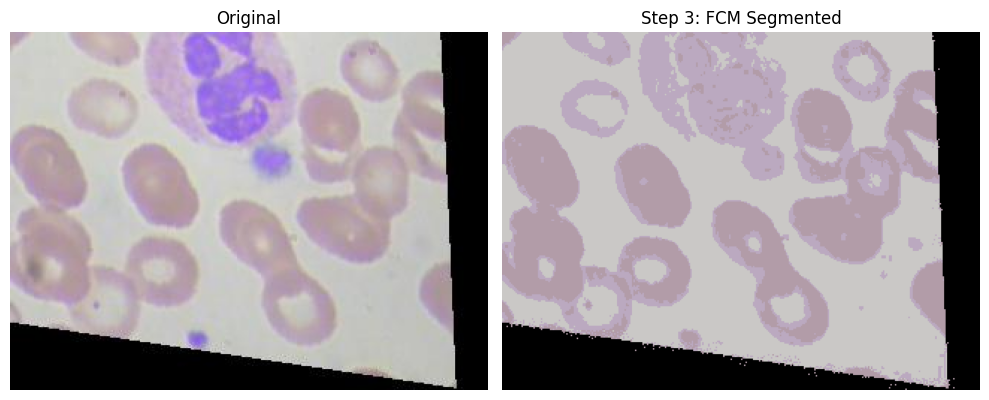

In [ ]:
def apply_fcm(filtered_pixels, clusters=3):
    data = filtered_pixels.T
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(data, c=clusters, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    return labels, cntr


print("Running Fuzzy C-Means...")
fcm_labels, cntr = apply_fcm(pixel_values_filtered)
segmented_image_fcm, full_labels_f = reconstruct_image(fcm_labels, cntr, non_black_mask, h, w)


plot_images([image_rgb, segmented_image_fcm], ["Original", "Step 3: FCM Segmented"])

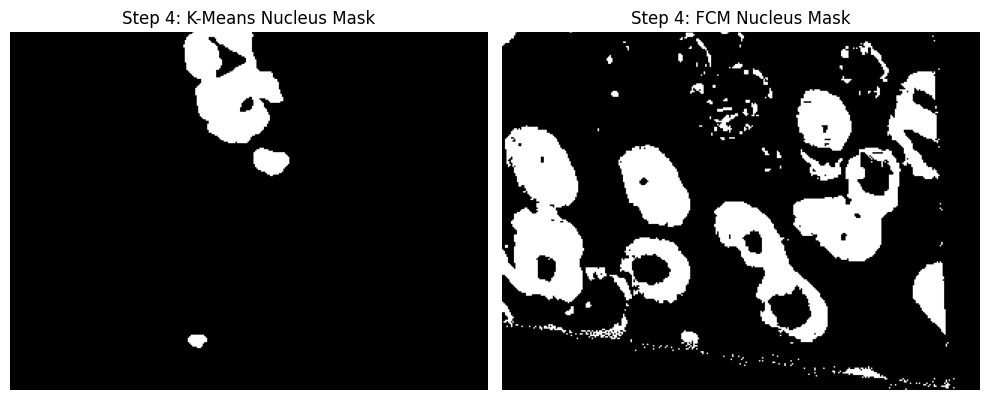

In [23]:
def get_nucleus_mask(centers, full_labels, method="brightness"):
    if method == "brightness":
        score = np.sum(centers, axis=1)
        cluster = np.argmin(score)  # Darkest cluster is usually the nucleus
    else:
        score = centers[:, 2] - centers[:, 1] 
        cluster = np.argmax(score)
    return (full_labels == cluster)

# Extract
kmeans_nucleus_mask = get_nucleus_mask(filtered_centers, full_labels_k)
fcm_nucleus_mask = get_nucleus_mask(cntr, full_labels_f)

# Show Output
plot_images([kmeans_nucleus_mask, fcm_nucleus_mask], 
            ["Step 4: K-Means Nucleus Mask", "Step 4: FCM Nucleus Mask"], cmap='gray')

--- Evaluation Metrics ---
Dice Score:    0.0484
Jaccard Index: 0.0248


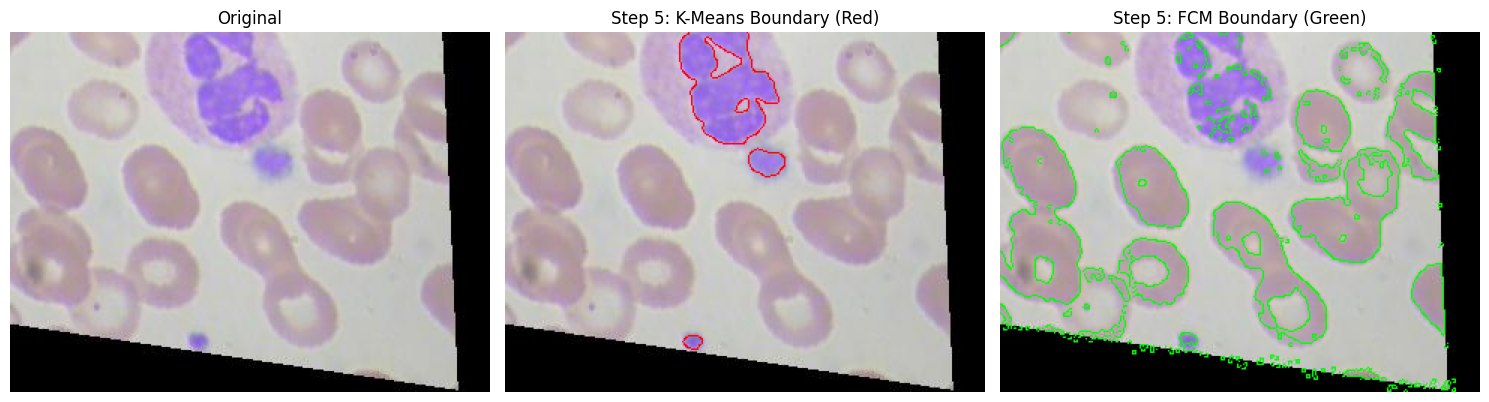

In [ ]:
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    return (2.0 * intersection) / (np.sum(mask1) + np.sum(mask2) + 1e-8)

def show_boundaries(image, mask, color):
    mask_uint8 = np.uint8(mask * 255)
    edges = cv2.Canny(mask_uint8, 50, 150)
    overlay = image.copy()
    overlay[edges > 0] = color
    return overlay

# Metrics
k_flat = kmeans_nucleus_mask.flatten().astype(int)
f_flat = fcm_nucleus_mask.flatten().astype(int)

print(f"--- Evaluation Metrics ---")
print(f"Dice Score:    {dice_score(k_flat, f_flat):.4f}")
print(f"Jaccard Index: {jaccard_score(f_flat, k_flat):.4f}")

# Boundaries
overlay_kmeans = show_boundaries(image_rgb, kmeans_nucleus_mask, [255, 0, 0]) # Red
overlay_fcm = show_boundaries(image_rgb, fcm_nucleus_mask, [0, 255, 0])       # Green

plot_images([image_rgb, overlay_kmeans, overlay_fcm], 
            ["Original", "Step 5: K-Means Boundary (Red)", "Step 5: FCM Boundary (Green)"])